# Passing prompts to the Segment Anything Model (SAM)

Although SAM can segment every single object in an image without any help from the user, there can be situations when you only need to segment certain parts of the image. For example, now we are only interested in the lungs.

If you need more details about SAM prompting, take a look at [this notebook][sam_notebook].

[sam_notebook]: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb "https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb"

First of all, import the required libraries:

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from skimage import measure

from tools.mask import Mask

We'll use this method to show some of the prompts:

In [2]:
# TODO: add documentation to this method, taken from SAM's notebooks.
# https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)

These variables store the path of the slices (image and masks) we are going to work with:

In [3]:
image_number = '001'
slice_number = '122'
data_folder_path = Path('data')
image_slice_path = data_folder_path / Path(f'coronacases_{image_number}_image_slice_{slice_number}.npy')
masks_slice_path = data_folder_path / Path(f'coronacases_{image_number}_masks_slice_{slice_number}.npy')

Let's load the image slice:

In [4]:
image_slice = np.load(image_slice_path)
image_slice.shape

(512, 512)

Now, let's load the masks slice:

In [5]:
masks_slice = np.load(masks_slice_path)
masks_slice.shape

(512, 512)

Now, let's prepare a list of points, placed in the center of each mask. These points will be positive prompts, this is, they mark the objects to find:

In [6]:
lungs_centers_of_mass = []
lungs_centers_of_mass_labels = []

lungs_masks_indexes = np.unique(masks_slice)
masks_indexes_len = len(lungs_masks_indexes)

if masks_indexes_len > 1:
    for lung_mask_index in lungs_masks_indexes:
        if lung_mask_index != 0:
            mask_points = masks_slice == lung_mask_index
            mask = Mask(mask_points)
            lung_center_of_mass = mask.get_center()
            lungs_centers_of_mass.append(lung_center_of_mass)


Add a new point to the list, the center of the image. We've noticed that it always lands outside the lungs, so it works in this case. It will be a negative prompt, this is, it represents what we don't want to segment:

In [7]:
if masks_indexes_len > 1:
    lungs_centers_of_mass.append([
        masks_slice.shape[0] // 2,
        masks_slice.shape[1] // 2
    ])
    lungs_centers_of_mass = np.array(lungs_centers_of_mass).astype(np.uint)

Now, let's label each point. Positive prompts with `1`, negative prompts with `0`:

In [8]:
if masks_indexes_len > 1:
    lungs_centers_of_mass_labels = np.ones(masks_indexes_len)
    lungs_centers_of_mass_labels[-1] = 0

Now, let's use the masks to create bounding boxes for each mask, and use them as positive prompts:

In [9]:
lungs_contours = []
lungs_contours_bounding_boxes = []

lungs_masks_indexes = np.unique(masks_slice)
masks_indexes_len = len(lungs_masks_indexes)
if masks_indexes_len > 1:
    for lung_mask_index in lungs_masks_indexes:
        if lung_mask_index != 0:
            mask_points = masks_slice == lung_mask_index
            lung_contours = measure.find_contours(mask_points)
            x_min = sys.float_info.max
            x_max = -1
            y_min = sys.float_info.max
            y_max = -1
            for lung_contour in lung_contours:
                lungs_contours.append(lung_contour)
                if np.min(lung_contour[:, 0]) < x_min:
                    x_min = np.min(lung_contour[:, 0])
                if np.max(lung_contour[:, 0]) > x_max:
                    x_max = np.max(lung_contour[:, 0])
                if np.min(lung_contour[:, 1]) < y_min:
                    y_min = np.min(lung_contour[:, 1])
                if np.max(lung_contour[:, 1]) > y_max:
                    y_max = np.max(lung_contour[:, 1])

            lungs_contours_bounding_boxes.append([x_min, x_max, y_min, y_max])

We've got everything we needed. Let's plot it:

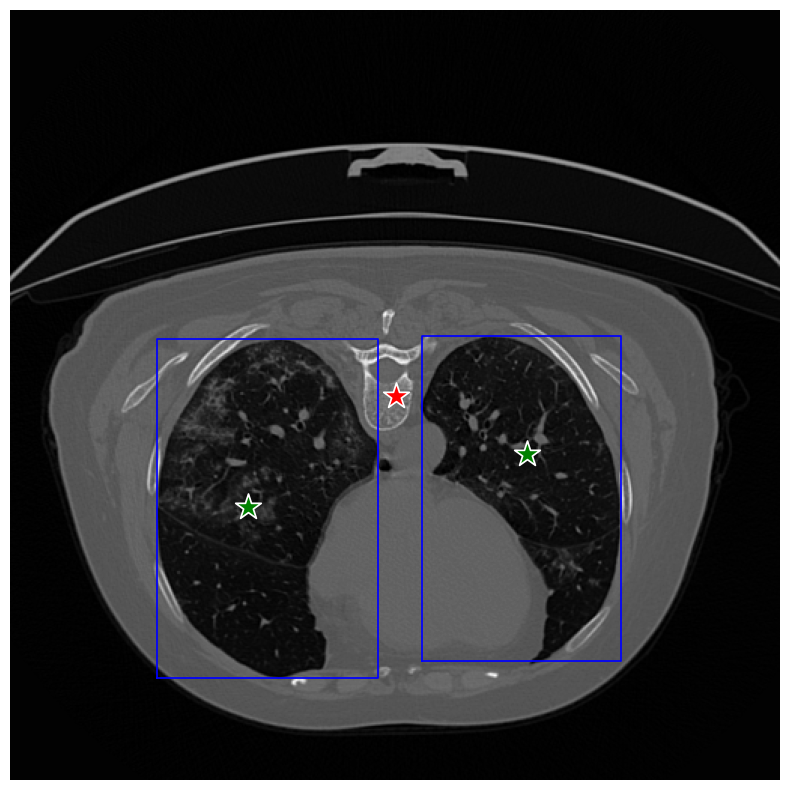

In [10]:
if masks_indexes_len > 1:
    figure = plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.style.use('grayscale')
    plt.imshow(np.fliplr(np.rot90(image_slice, k=3)))
    show_points(
        coords=lungs_centers_of_mass,
        labels=lungs_centers_of_mass_labels,
        ax=plt.gca())
    for lung_contours_bounding_box in lungs_contours_bounding_boxes:
        xs = [lung_contours_bounding_box[0],
              lung_contours_bounding_box[1],
              lung_contours_bounding_box[1],
              lung_contours_bounding_box[0],
              lung_contours_bounding_box[0]]
        ys = [lung_contours_bounding_box[3],
              lung_contours_bounding_box[3],
              lung_contours_bounding_box[2],
              lung_contours_bounding_box[2],
              lung_contours_bounding_box[3]]
        plt.plot(xs, ys, color='blue', linewidth=1.25)